# Look at all the stars for which you do have RVs.

In [1]:
%matplotlib inline

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tqdm

import astropy.stats as aps

import aviary as av

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load data and make cuts.

In [103]:
df = pd.read_csv("../../data/gaia_mc.csv")
print(len(df))

travis = pd.read_csv("../../data/Ruth_McQuillan_Masses_Out.csv")
masses = pd.DataFrame(dict({"kepid": travis.KIC.values, "Mass": travis.iso_mass.values}))
masses.head()
df = pd.merge(masses, df, how="right", on="kepid", suffixes=["_berger", ""])

# Load Santos data
# big_prot_table = pd.read_pickle("../../data/Mc_Gar_Sant")
# gaia_mc = pd.merge()

# # Cut out photometric binaries.
# m = df.flag.values == 1
# df = gaia_mc.iloc[m]*1
# print(np.shape(df), "no visual binaries or subgiants")

la = pd.read_csv("../../data/Kepler-LAMOST-outdated.csv")
df = pd.merge(la, df, how="right", left_on="KIC", right_on="kepid")
print(len(df))

35564
35659


Use Gaia RVs where available, and LAMOST RVs where unavailable.

In [104]:
rv, rv_err = [np.zeros(len(df)) for i in range(2)]

ml = np.isfinite(df.RV_LAM.values)
rv[ml] = df.RV_LAM.values[ml]
print(sum(ml), "stars with LAMOST RVs")

# mg = gaia_mc.radial_velocity.values != 0
mg = np.isfinite(df.radial_velocity.values)
rv[mg] = df.radial_velocity.values[mg]
rv_err[mg] = df.radial_velocity_error.values[mg]
print(sum(mg), "stars with Gaia RVs")

df["rv"] = rv
df["rv_err"] = rv_err

# gaia_mc.to_csv("../../data/gaia_lamost_mc_cuts.csv")
df.to_csv("../../data/gaia_lamost_mc.csv")

m = df.rv.values != 0
gaia_mc = df.iloc[m]
print(len(gaia_mc), "stars with RVs in total")

9385 stars with LAMOST RVs
3803 stars with Gaia RVs
10741 stars with RVs in total


Calculate velocities from LAMOST RVs.

In [99]:
# for i, row in enumerate(df):
xyz, vxyz = av.simple_calc_vxyz(gaia_mc.ra.values, gaia_mc.dec.values,
                                1./gaia_mc.parallax.values, gaia_mc.pmra.values,
                                gaia_mc.pmdec.values, gaia_mc.radial_velocity.values)

vx, vy, vz = vxyz
x, y, z = xyz

gaia_mc = gaia_mc.copy(deep=True)
gaia_mc["basic_vx"] = vx.value
gaia_mc["basic_vy"] = vy.value
gaia_mc["basic_vz"] = vz.value

gaia_mc["x"] = x.value
gaia_mc["y"] = y.value
gaia_mc["z"] = z.value

vx, vx_err, vy, vy_err, vz, vz_err = av.calc_vxyz(gaia_mc)
gaia_mc["vx_cov"] = vx
gaia_mc["vx_cov_err"] = vx_err
gaia_mc["vy_cov"] = vy
gaia_mc["vy_cov_err"] = vy_err
gaia_mc["vz_cov"] = vz
gaia_mc["vz_cov_err"] = vz_err

In [100]:
gaia_mc.to_csv("../../data/gaia_lamost_mc_velocities.csv")
# gaia_mc.to_csv("../../data/gaia_lamost_mc_velocities_cuts.csv")

In [101]:
# dt, dp = 250, .15
dt, dp = 500, .4

dispersions_bins = aviary.calc_dispersion_bins(gaia_mc.color_teffs.values,
                                               np.log10(gaia_mc.Prot.values),
                                               gaia_mc.basic_vz.values,
                                               dt, dp)

 14%|█▍        | 1524/10741 [00:00<00:01, 4924.79it/s]/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
100%|██████████| 10741/10741 [00:02<00:00, 4944.31it/s]


(6700, 3200)

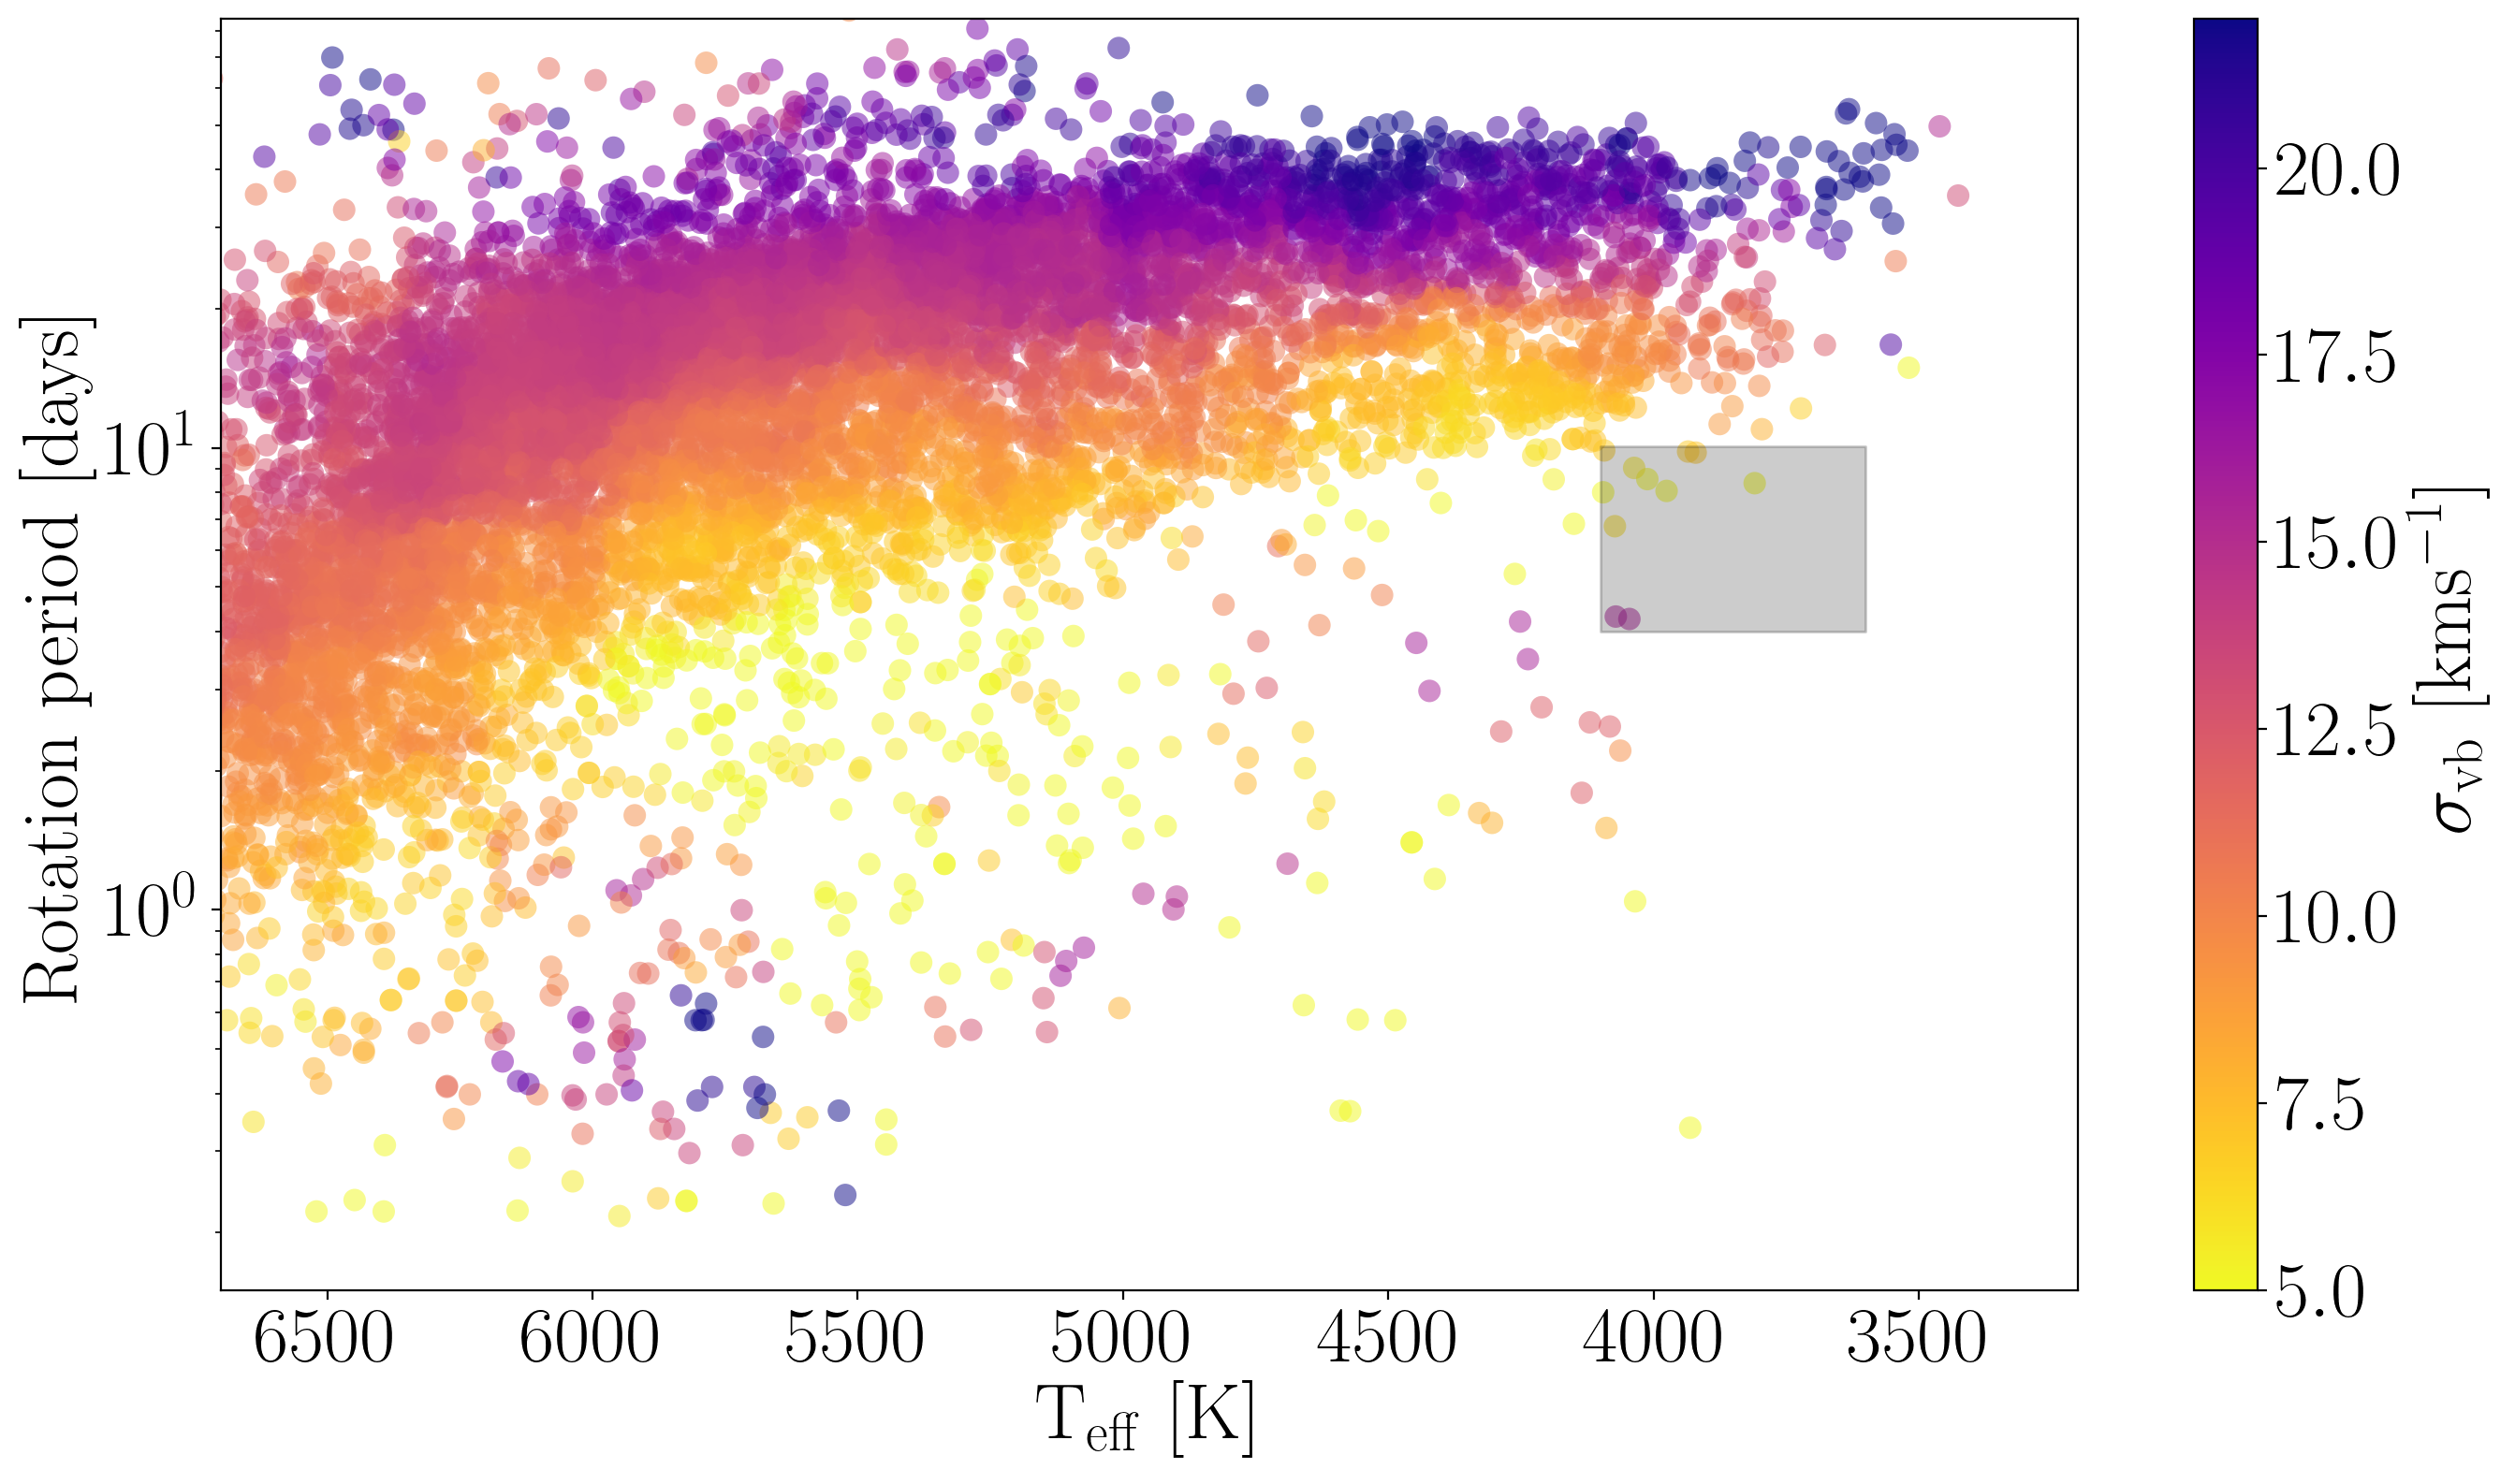

In [102]:
plt.figure(figsize=(16, 9), dpi=200)

plt.scatter(gaia_mc.color_teffs, gaia_mc.Prot, c=dispersions_bins,
            s=75, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap="plasma_r", zorder=1)
plt.yscale("log")
plt.xlim(6550, 3300)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

color_bar = plt.colorbar(label="$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
color_bar.set_alpha(1)
color_bar.draw_all()

xs = np.arange(3000, 6000, dt)
ys = 10**np.arange(1, 2, dp)
    
xspot, yspot = 3600, 4
xs = np.linspace(xspot, xspot+dt, 100)
plt.fill_between(xs, yspot, 10**(np.log10(yspot) + dp), color="k", alpha=.2)

plt.ylim(.15, 85)
plt.xlim(6700, 3200)

(6700, 3200)

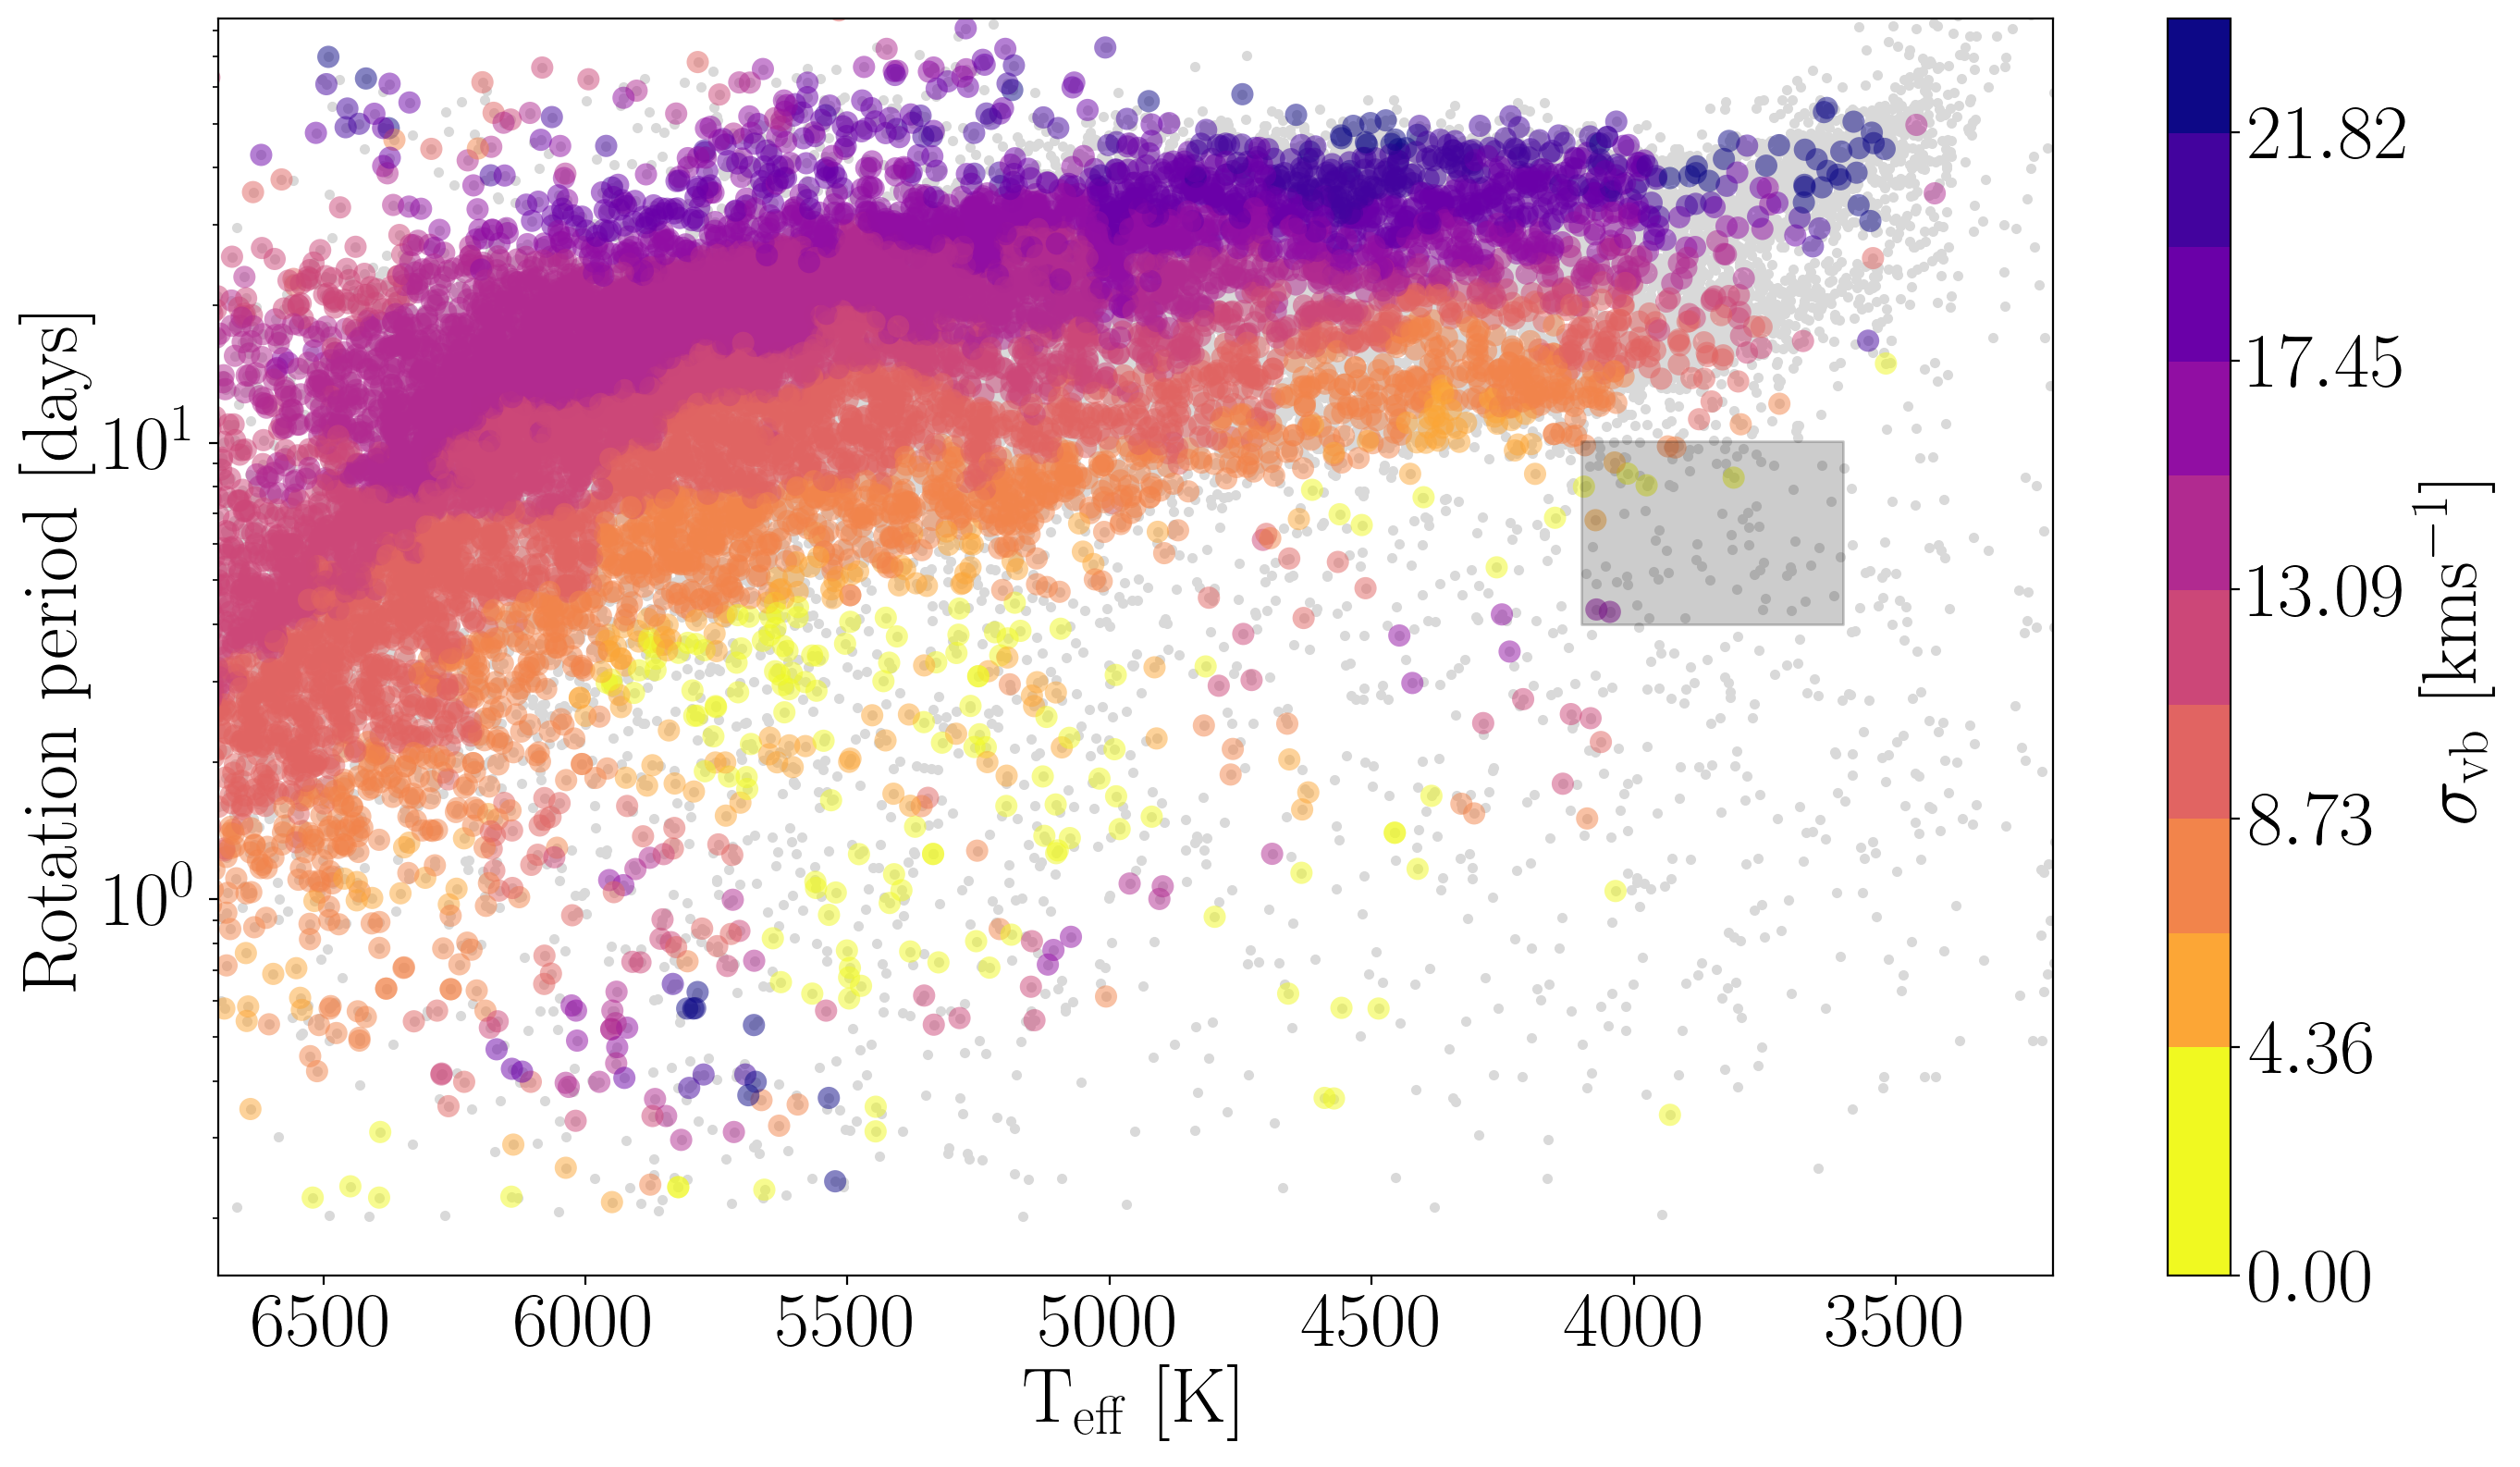

In [108]:
cmap = plt.cm.plasma_r
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 24, 12)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(16, 9), dpi=200)

plt.plot(df.color_teffs, df.Prot, ".", color=".85", zorder=0)
plt.scatter(gaia_mc.color_teffs, gaia_mc.Prot, c=dispersions_bins,
            s=75, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap=cmap, norm=norm, zorder=1)
plt.yscale("log")
plt.xlim(6550, 3200)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

color_bar = plt.colorbar(label="$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
color_bar.set_alpha(1)
color_bar.draw_all()

xs = np.arange(3000, 6000, dt)
ys = 10**np.arange(1, 2, dp)
    
xspot, yspot = 3600, 4
xs = np.linspace(xspot, xspot+dt, 100)
plt.fill_between(xs, yspot, 10**(np.log10(yspot) + dp), color="k", alpha=.2)

plt.ylim(.15, 85)
plt.xlim(6700, 3200)